# T-S diagrams and comparison

For reference: https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/TemperatureSalinityDiagrams.ipynb

In [2]:
import dask
import dask.array as da
import dask.dataframe as dd
from dask import delayed
import numpy as np
import xarray as xr
from distributed.diagnostics.progressbar import progress
import cosima_cookbook as cc
import gsw
import cf_xarray as cfxr
from xhistogram.xarray import histogram as xhistogram

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean as cmo


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
display(client)

<Client: 'tcp://127.0.0.1:43641' processes=5 threads=20, memory=200.00 GiB>

In [6]:
# database for control simulation:
session_name = '/g/data/v45/wf4500/databases/gdata_01deg_jra55v13_ryf9091_DSW.db'
master_session = cc.database.create_session(session_name)
control = '01deg_jra55v13_ryf9091_DSW'
#session_name = '/home/156/wf4500/databases/access/DSW.db'
#master_session = cc.database.create_session(session_name)
#control = '01deg_jra55v13_ryf9091_21mbath'

# basal melt experiments
basal_gade = 'accessom2-GPC023'
icb_gade = 'accessom2-GPC026'

start_time='1909-01-01'
end_time='1910-01-01'

lat_slice = slice(-80,-59)
lon_slice = slice(-280,80)

In [10]:
# build database for basal melt experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

Get bathymetry. 

In [7]:
# get bathymetry
ht = cc.querying.getvar(control, 'ht', master_session, n=1).sel(yt_ocean=lat_slice)

In [8]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    masked_var = masked_var.rename(var.name)
    masked_var.attrs['units'] = var.attrs['units']
    return masked_var, shelf_map

# Histogram T-S plots

In [6]:
# dictionary of variable names and time for mom5 
vars_args = {
    "mom5": {
        "var_temp": 'temp',
        "var_salt": 'salt',
        "var_area": 'area_t'},}


def gsw_SA_from_SP(salt, lon_name):
    """function to convert practical salinity to absolute salinity
    using the Gibbs SeaWater (GSW) Oceanographic Toolbox of TEOS-10
    (https://teos-10.github.io/GSW-Python/)
    
    input:
        -salt: practical salinity (array)
        -lon_name: name of the longitude (str)
    output:
        -salt_abs: absolute salinity (array)
    """
    pres = gsw.p_from_z(-salt.cf['vertical'], salt.cf['latitude'])
    salt_abs = gsw.SA_from_SP(salt, pres, salt[lon_name], salt.cf['latitude'])
    salt_abs.attrs = {'units': 'Absolute Salinity (g/kg)'}
    return salt_abs

# a function to load salinity
def load_salinity(model, session):
    salt = cc.querying.getvar(
        variable=vars_args[model].get('var_salt'), session=session, frequency='1 monthly',
        **expt_args[model])
    lon_name = salt.cf['longitude'].name
    # select longitude, latitude range and time
    salt = salt.cf.sel(longitude=lon_slice).cf.sel(
        latitude=lat_slice, time=slice(start_time, end_time))
    # convert from practical to absolute salinity
    salt = gsw_SA_from_SP(salt, lon_name)
    return salt

# a function to load temperature
def load_temperature(model, session):
    temp = cc.querying.getvar(
        variable=vars_args[model].get('var_temp'), session=session, frequency='1 monthly',
        **expt_args[model])
    # select longitude, latitude range and time
    temp = temp.cf.sel(longitude=lon_slice).cf.sel(
        latitude=lat_slice, time=slice(start_time, end_time))
    temp = temp - 273.15
    temp.attrs = {'units': 'Conservative temperature (°C)'}
    return temp

# a function to load area of grid cells
def load_grid_areas(model, session):
    area = cc.querying.getvar(
        variable=vars_args[model].get('var_area'), session=session, n=1,
        **expt_args[model])
    if model == 'mom5':
        area = area.drop(['geolon_t', 'geolat_t'])
    # select longitude and latitude range
    area = area.cf.sel(longitude=lon_slice).cf.sel(
        latitude=lat_slice)
    return area

Load data

In [76]:
%%time
# dictionary of experiment name and time for mom5 
expt = '01deg_jra55v13_ryf9091_DSW'
expt_args = {"mom5": {
        "expt": f"{expt}",
        "start_time": "1909-01-01",
        "end_time": "1910-12-31"},}
print(expt_args)
model = 'mom5'  # 'mom5' or 'mom6'
salt = load_salinity(model, master_session)
temp = load_temperature(model, master_session)
area = load_grid_areas(model, master_session)
# mask to shelf
salt, shelf_map = shelf_mask_isobath(salt)
temp, shelf_map = shelf_mask_isobath(temp)
area, shelf_map = shelf_mask_isobath(area)

expt = basal_gade
expt_args = {"mom5": {
        "expt": f"{expt}",
        "start_time": "1909-01-01",
        "end_time": "1910-12-31"},}
print(expt_args)
salt_basal = load_salinity(model, basal_melt_session)
temp_basal = load_temperature(model, basal_melt_session)
area_basal = load_grid_areas(model, basal_melt_session)
salt_basal, shelf_map = shelf_mask_isobath(salt_basal)
temp_basal, shelf_map = shelf_mask_isobath(temp_basal)
area_basal, shelf_map = shelf_mask_isobath(area_basal)

expt = icb_gade
expt_args = {"mom5": {
        "expt": f"{expt}",
        "start_time": "1909-01-01",
        "end_time": "1910-12-31"},}
print(expt_args)
salt_icb = load_salinity(model, basal_melt_session)
temp_icb = load_temperature(model, basal_melt_session)
area_icb = load_grid_areas(model, basal_melt_session)
salt_icb, shelf_map = shelf_mask_isobath(salt_icb)
temp_icb, shelf_map = shelf_mask_isobath(temp_icb)
area_icb, shelf_map = shelf_mask_isobath(area_icb)

{'mom5': {'expt': '01deg_jra55v13_ryf9091_DSW', 'start_time': '1909-01-01', 'end_time': '1910-12-31'}}
{'mom5': {'expt': 'accessom2-GPC023', 'start_time': '1909-01-01', 'end_time': '1910-12-31'}}
{'mom5': {'expt': 'accessom2-GPC026', 'start_time': '1909-01-01', 'end_time': '1910-12-31'}}
CPU times: user 1.98 s, sys: 158 ms, total: 2.14 s
Wall time: 3.25 s


Create historgrams

In [81]:
# a function that computes the temperature and salinity bins for 2D histogram 
def compute_TS_bins(salt, temp, area):
    temp_bins = np.arange(np.floor(temp.min().values), np.ceil(temp.max().values+2), 0.5)
    salt_bins = np.arange(np.floor(salt.min().values), np.ceil(salt.max().values), 0.1)
    # for density contours in TS diagram
    temp_bins_mesh,salt_bins_mesh = np.meshgrid(temp_bins, salt_bins)
    TS_density = gsw.density.sigma0(salt_bins_mesh, temp_bins_mesh)
    # volume of grid cells to account for varying grid cells especially in the vertical
    vol = (temp.cf['vertical'] * area)

    # 2D histogram of temperature and salinity weighted by volume
    TS_hist = xhistogram(
        temp, salt, bins=(temp_bins, salt_bins), weights=vol)
    TS_hist = TS_hist.where(TS_hist != 0).compute()
    return TS_hist, TS_density, salt_bins_mesh, temp_bins_mesh 

In [78]:
%%time
TS_hist, TS_density, salt_bins_mesh, temp_bins_mesh = compute_TS_bins(salt, temp, area)
TS_hist_basal, TS_density_basal, salt_bins_mesh_basal, temp_bins_mesh_basal = compute_TS_bins(salt_basal, temp_basal, area_basal)
TS_hist_icb, TS_density_icb, salt_bins_mesh_icb, temp_bins_mesh_icb = compute_TS_bins(salt_icb, temp_icb, area_icb)

2023-08-23 18:36:21,681 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-08-23 18:36:33,398 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-08-23 18:36:59,250 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-08-23 18:37:09,255 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-08-23 18:37:16,291 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-08-23 18:37:18,304 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-08-23 18:37:23,710 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-08-23 18:37:23,926 - distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 4min 29s, sys: 12.6 s, total: 4min 41s
Wall time: 6min 33s


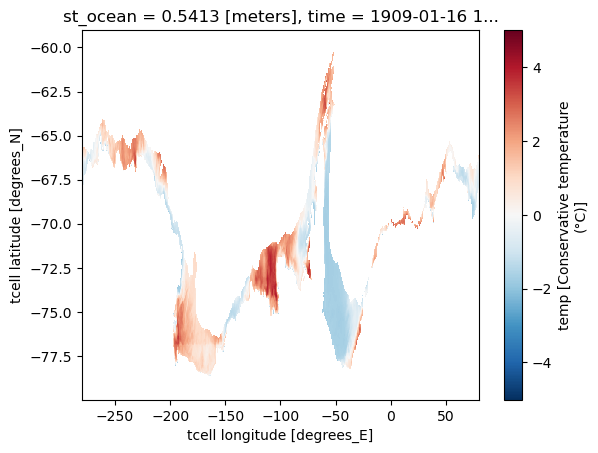

In [83]:
temp_basal.isel(time=0).isel(st_ocean=0).plot(figsize=(6,3))
plt.show()


Plot histograms

In [47]:
salt_arr = np.arange(25, 40, 0.1)
tfreeze_arr = gsw.CT_freezing(salt_arr, 1, 0.1)
tfreeze_arr_1000 = gsw.CT_freezing(salt_arr, 1000, 0.1)
tfreeze_arr_2000 = gsw.CT_freezing(salt_arr, 2000, 0.1)

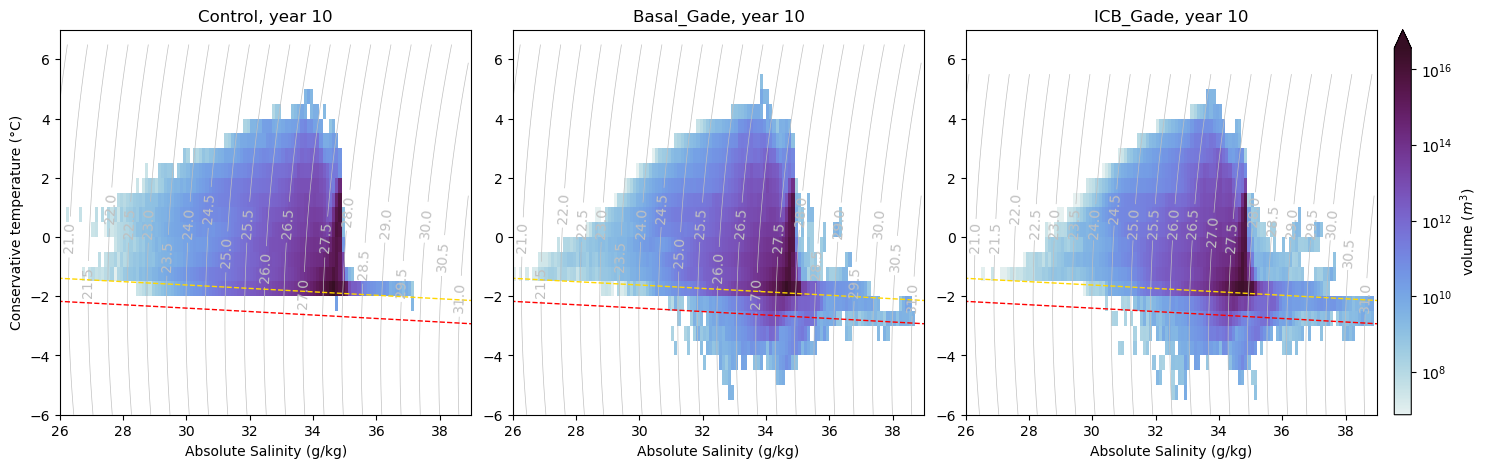

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
plt.subplots_adjust(wspace=0.1)

norm=colors.LogNorm(vmin=TS_hist.min().values, vmax=TS_hist.max().values)

# Control
# volume weighted histogram of T and S
cb = axes[0].pcolormesh(TS_hist.salt_bin, TS_hist.temp_bin, TS_hist,  cmap=cmo.cm.dense, norm=norm)
# sigma_0 contours
cs = axes[0].contour(salt_bins_mesh_basal, temp_bins_mesh_basal, TS_density_basal, colors='silver',linewidths=0.5,
                 levels=np.arange(np.floor(TS_density_basal.min()),np.ceil(TS_density_basal.max()), .5), )
axes[0].plot(salt_arr, tfreeze_arr, 'gold', lw=1, ls='--')
axes[0].plot(salt_arr, tfreeze_arr_1000, 'r', lw=1, ls='--')
axes[0].set_ylim([-6, 7])
axes[0].set_xlim([26, 39])
plt.clabel(cs, inline=True)

# As above but for Basal_Gade
cb = axes[1].pcolormesh(TS_hist_basal.salt_bin, TS_hist_basal.temp_bin, TS_hist_basal,  cmap=cmo.cm.dense, norm=norm)
cs = axes[1].contour(salt_bins_mesh_basal, temp_bins_mesh_basal, TS_density_basal, colors='silver',linewidths=0.5,
                 levels=np.arange(np.floor(TS_density_basal.min()),np.ceil(TS_density_basal.max()), .5), 
                )
axes[1].plot(salt_arr, tfreeze_arr, 'gold', lw=1, ls='--')
axes[1].plot(salt_arr, tfreeze_arr_1000, 'r', lw=1, ls='--')
#axes[1].plot(salt_arr, tfreeze_arr_2000, 'cyan', lw=1, ls='--')
plt.clabel(cs, inline=True)
axes[1].set_ylim([-6, 7])
axes[1].set_xlim([26, 39])

# As above but for ICB_Gade
cb = axes[2].pcolormesh(TS_hist_icb.salt_bin, TS_hist_icb.temp_bin, TS_hist_icb,  cmap=cmo.cm.dense, norm=norm)
cs = axes[2].contour(salt_bins_mesh_icb, temp_bins_mesh_icb, TS_density_icb, colors='silver',linewidths=0.5,
                 levels=np.arange(np.floor(TS_density_icb.min()),np.ceil(TS_density_icb.max()), .5), )
plt.clabel(cs, inline=True)
axes[2].plot(salt_arr, tfreeze_arr, 'gold', lw=1, ls='--')
axes[2].plot(salt_arr, tfreeze_arr_1000, 'r', lw=1, ls='--')
axes[2].set_ylim([-6, 7])
axes[2].set_xlim([26, 39])

# add colorbar
cax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
fig.colorbar(cb, cax=cax, orientation='vertical', extend='max', label='volume ($m^{3}$)')

# add axes labels
axes[0].set_xlabel(salt.units)
axes[1].set_xlabel(salt.units)
axes[2].set_xlabel(salt.units)
axes[0].set_ylabel(temp.units)

# add titles
axes[0].set_title('Control, year 10')
axes[1].set_title('Basal_Gade, year 10')
axes[2].set_title('ICB_Gade, year 10')

plt.show()

**Q: Where are these negative temp values coming from in basal and icb gade simulations?**

A: Primarily close to ice shelves in the West Antarctic region. Also some locations in East Antarctica. 

In [199]:
%%time
temp_icb_neg = temp_icb.where(temp_icb <= -2.5, np.nan).min(dim='st_ocean').min(dim='time').compute()
temp_basal_neg = temp_basal.where(temp_basal <= -2.5, np.nan).min(dim='st_ocean').min(dim='time').compute()

CPU times: user 29 s, sys: 1.31 s, total: 30.3 s
Wall time: 39.4 s


In [190]:
ht_tmp = ht.where(np.isfinite(ht), 1.)
ht_tmp = ht_tmp.where(ht_tmp <=1., 0.)

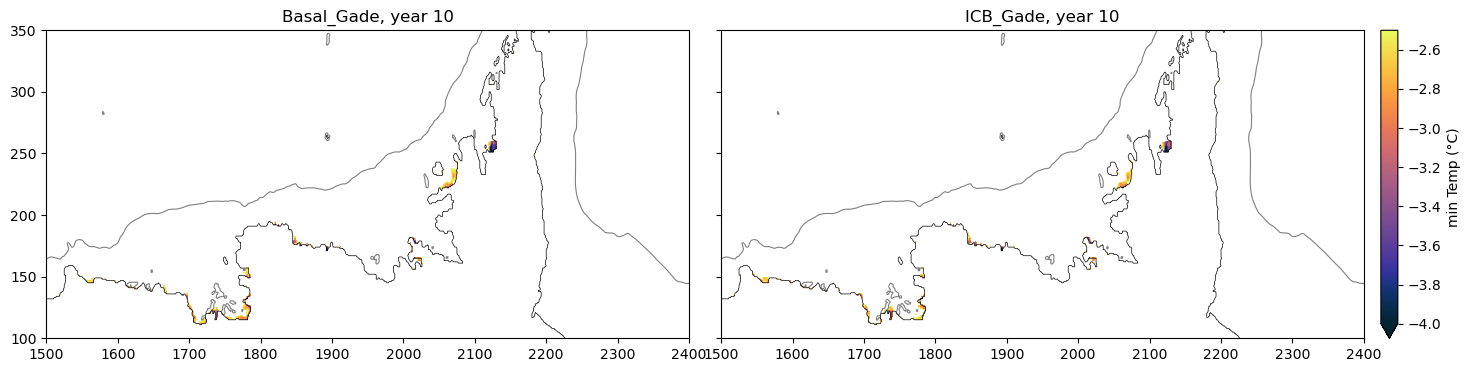

In [209]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05)

axes[0].contour(ht_tmp,levels=[1.], zorder=2, colors='k', linewidths=0.5)
axes[0].contour(ht,levels=[1000], zorder=1, colors='grey', linewidths=0.8)
axes[0].pcolormesh(temp_basal_neg, zorder=0, cmap=cmo.cm.thermal, vmin=-4, vmax=-2.5)

axes[1].contour(ht_tmp,levels=[1.], zorder=2, colors='k', linewidths=0.5)
axes[1].contour(ht,levels=[1000], zorder=1, colors='grey', linewidths=0.8)
cb = axes[1].pcolormesh(temp_icb_neg, zorder=0, cmap=cmo.cm.thermal, vmin=-4, vmax=-2.5 )

cax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
fig.colorbar(cb, cax=cax, orientation='vertical', extend='min',label='min Temp (°C)')

axes[0].set_title('Basal_Gade, year 10')
axes[1].set_title('ICB_Gade, year 10')

axes[1].set_xlim([1500,2400])
axes[1].set_ylim([100,350])

plt.show()

# Regional T-S plots

Define functions to read in data from control and simulation

In [4]:
def read_and_convert_TS(lat_slice, lon_slice, start_time, end_time):
    '''
    Reads T and S from control and Tfreeze_min simulation
    Restricts to shelf and region given by lat_slice and lon_slice
    Convert TS using gsw
    '''
    
    # control run
    temp = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    salt = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    ## Basal Gade run
    temp_basal_gade = cc.querying.getvar(basal_gade, 'temp', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    salt_basal_gade = cc.querying.getvar(basal_gade, 'salt', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    # ICB Gade run
    temp_icb_gade = cc.querying.getvar(icb_gade, 'temp', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    salt_icb_gade = cc.querying.getvar(icb_gade, 'salt', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

    # subset temp and salinity only for shelf values
    temp = temp.where(ht<1000)
    salt = salt.where(ht<1000)
    temp_basal_gade = temp_basal_gade.where(ht<1000)
    salt_basal_gade = salt_basal_gade.where(ht<1000)
    temp_icb_gade = temp_icb_gade.where(ht<1000)
    salt_icb_gade = salt_icb_gade.where(ht<1000)
    
    # interpolate to evenly spaced 50 m vertical grid and load data
    z_even = np.arange(1,1051,50)
    salt = salt.interp(st_ocean = z_even).load()
    temp = temp.interp(st_ocean = z_even).load()
    salt_basal_gade = salt_basal_gade.interp(st_ocean = z_even).load()
    temp_basal_gade = temp_basal_gade.interp(st_ocean = z_even).load()
    salt_icb_gade = salt_icb_gade.interp(st_ocean = z_even).load()
    temp_icb_gade = temp_icb_gade.interp(st_ocean = z_even).load()

    # subset for first region and load data
    #temp = temp.load()
    #salt = salt.load()
    #temp_basal_gade = temp_basal_gade.load()
    #salt_basal_gade= salt_basal_gade.load()
    #temp_icb_gade = temp_icb_gade.load()
    #salt_icb_gade= salt_icb_gade.load()
    print('Temp is' , temp.nbytes/1000**3, 'GB')
    
    # convert Temp to deg C
    temp = temp - 273.15
    temp_basal_gade = temp_basal_gade - 273.15
    temp_icb_gade = temp_icb_gade - 273.15
    # convert salinity (psu) to absolute salinity
    p = gsw.p_from_z(-salt.st_ocean,salt.yt_ocean)
    salt = gsw.SA_from_SP(salt, p, salt.xt_ocean, salt.yt_ocean)
    salt_basal_gade = gsw.SA_from_SP(salt_basal_gade, p, salt_basal_gade.xt_ocean, salt_basal_gade.yt_ocean)
    salt_icb_gade = gsw.SA_from_SP(salt_icb_gade, p, salt_icb_gade.xt_ocean, salt_icb_gade.yt_ocean)
     
    return temp,salt,temp_basal_gade,salt_basal_gade,temp_icb_gade,salt_icb_gade


Define figure functions

In [5]:
def figure(region):
    plt.rcParams['font.size'] = 13
    fig, axes = plt.subplots(1,3, figsize=(21,6))
    sig_lvls = [24, 24.5, 25, 25.5, 26, 26.5, 27, 27.25, 27.5, 27.75, 28, 28.25, 28.5]
    for ax in axes.flatten():
        ax.set_ylim([-2,2])
        ax.set_xlim([32,35])
        ax.set_ylabel('Conservative Temperature (\u00b0C)')
        ax.set_xlabel('Absolute Salinity (g/kg)')
        cl = ax.contour(salt_mesh,temp_mesh,sigma0_for_contouring, sig_lvls,colors='lightgrey',linewidths=1)
        ax.clabel(cl, sig_lvls)
        
        salt_arr = np.arange(27, 37, 0.1)
        tfreeze_arr = gsw.CT_freezing(salt_arr, 1, 0.1)
        ax.plot(salt_arr, tfreeze_arr, 'dimgrey', lw=1, ls='--')
        
    return fig, axes, region

def create_colour_array(salt):
    # create depth arrays for colouring scatter plot
    depth = salt.copy(deep=True)
    depth.rename('depth')
    for i in range(len(depth.st_ocean)):
        depth[:,i,:,:] = depth.st_ocean[i]

    # create latitude arrays for colouring scatter plot
    lat_arr = salt.copy(deep=True)
    lat_arr.rename('lat')
    for i in range(len(salt.yt_ocean)):
        lat_arr[:,:,i,:] = lat_arr.yt_ocean[i]
        
    return depth, lat_arr

# create density mesh for contours on T-S
temp_vals = np.arange(-3.5,2,.1)
salt_vals = np.arange(26,36.5,.01) 
temp_mesh,salt_mesh = np.meshgrid(temp_vals,salt_vals)
density_for_contouring = gsw.density.rho(salt_mesh, temp_mesh, 1) #- 1000
sigma0_for_contouring = gsw.density.sigma0(salt_mesh, temp_mesh)
sigma1_for_contouring = gsw.density.sigma1(salt_mesh, temp_mesh)

# define colourmap for T-S plots
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = plt.get_cmap('YlGnBu')
new_cmap = truncate_colormap(cmap, 0.2, 1)
new_cmap


## Regions:
- Southern Weddell Sea
- Southwest Ross Sea
- Amery Ice Shelf
- Amundsen Sea
- Bellingshausen Sea
- East Antarctica Adelie region

In [6]:
def plot_box(lon1, lon2,lat1, lat2):
    plt.plot([lon1,lon1],[lat1,lat2],c='k')
    plt.plot([lon2,lon2],[lat1,lat2],c='k')
    plt.plot([lon1,lon2],[lat1,lat1],c='k')
    plt.plot([lon1,lon2],[lat2,lat2],c='k')

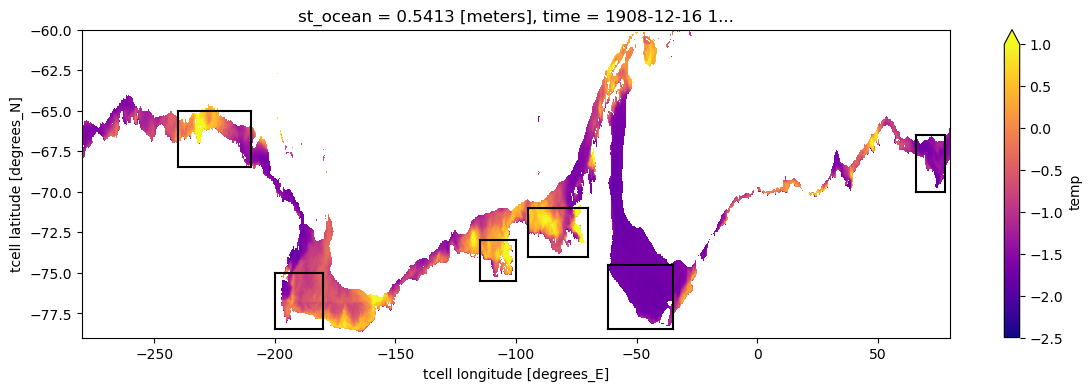

In [17]:
# last year only
start_time='1909-01-01'
end_time='1910-01-01'
lat_slice = slice(-79,-60)
lon_slice = slice(-280,80)
# read in T and S for region
temp = cc.querying.getvar(basal_gade, 'temp', basal_melt_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp = temp.where(ht<1000)
# plot regions of interest for quick reference check
(temp[0,0,:,:]-273.15).plot(figsize=(14,4), cmap='plasma', vmin=-2.5, vmax=1)

#amundsen
l,r = -115, -100
b,t = -75.5, -73
plot_box(l,r,b,t)
#bellingshausen
l,r = -95, -70
b,t = -74, -71
plot_box(l,r,b,t)
#Cape Darnley region
l,r = 66, 78
b,t = -70, -66.5
plot_box(l,r,b,t)
#East Antarctica - Adelie region
l,r = -240, -210
b,t = -68.5, -65
plot_box(l,r,b,t)
#south-west ross sea
l,r = -200, -180
b,t = -78.5, -75
plot_box(l,r,b,t)
#Southern weddell sea
l,r = -62, -35
b,t = -78.5, -74.5
plot_box(l, r,b, t)
# Antarctic Peninsula

plt.ylim(-79, -60)
plt.show()

In [94]:
bounds = {}
bounds['Cape Darnley'] = (66, 78, -70, -66.5)
bounds['East Antarctica - Adelie'] = (-240, -210, -68.5, -65)
bounds['Ross Sea'] = (-200, -180, -78.5, -75)
bounds['Amundsen Sea'] = (-115, -100, -75.5, -73)
bounds['Bellingshausen Sea'] = (-95, -70, -74, -71)
bounds['Weddell Sea'] = (-62, -35, -78.5, -74.5)

Cape Darnley (66, 78, -70, -66.5)
Temp is 0.0250992 GB


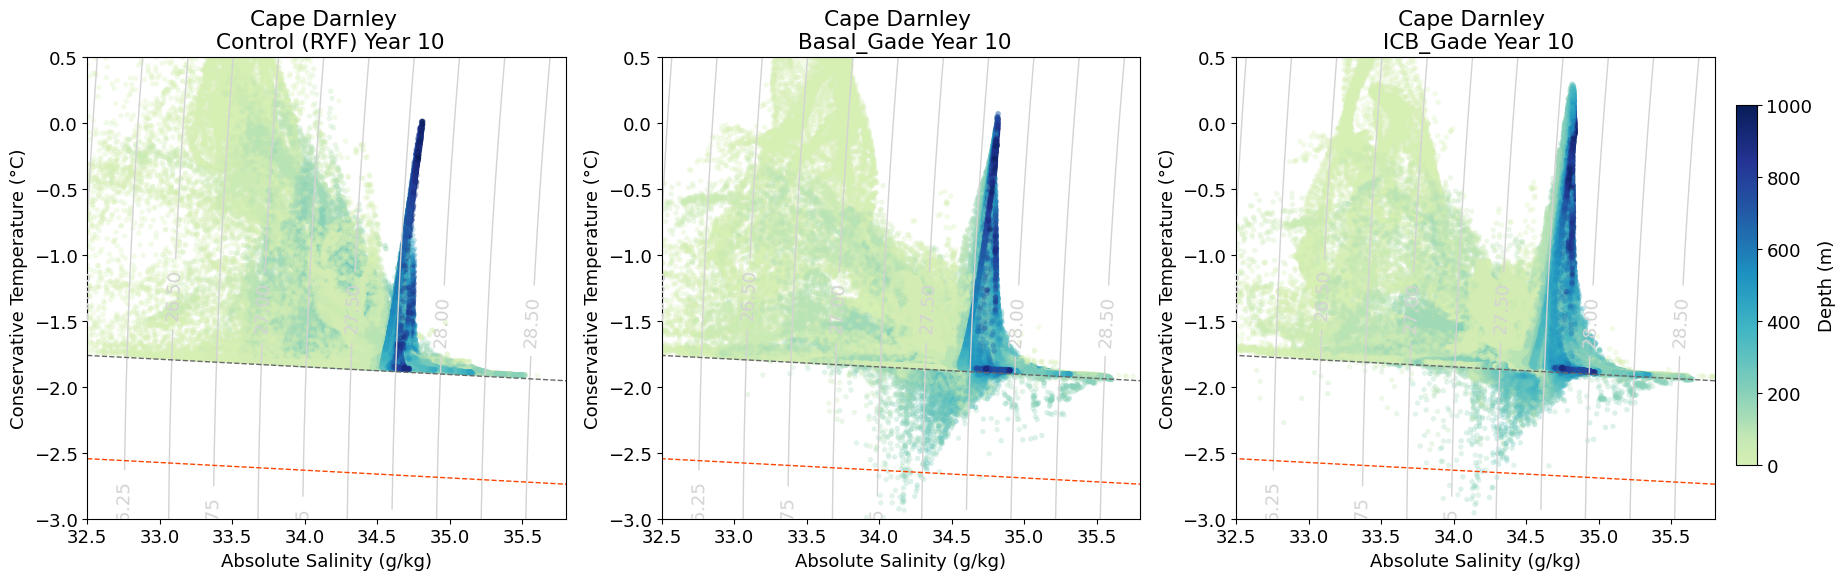

East Antarctica - Adelie (-240, -210, -68.5, -65)
Temp is 0.062748 GB


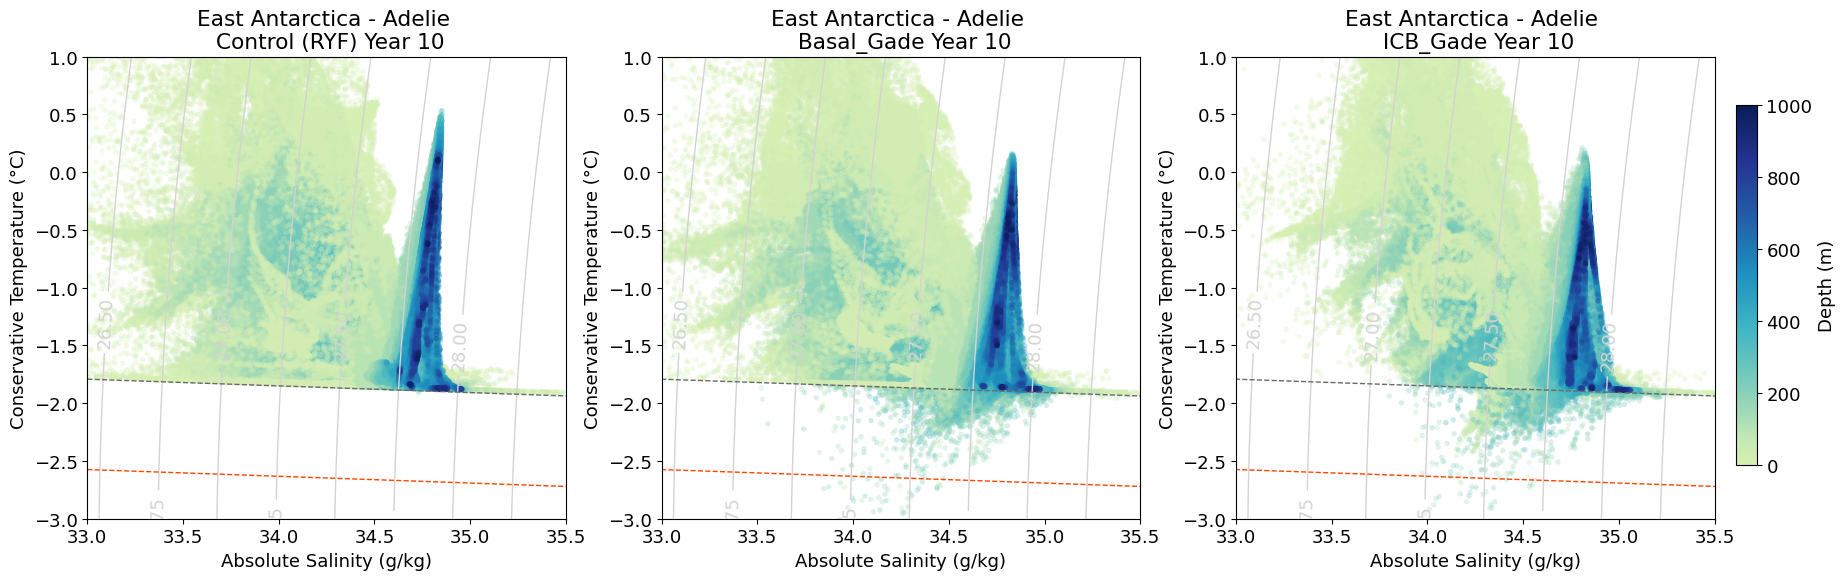

Ross Sea (-200, -180, -78.5, -75)
Temp is 0.041832 GB


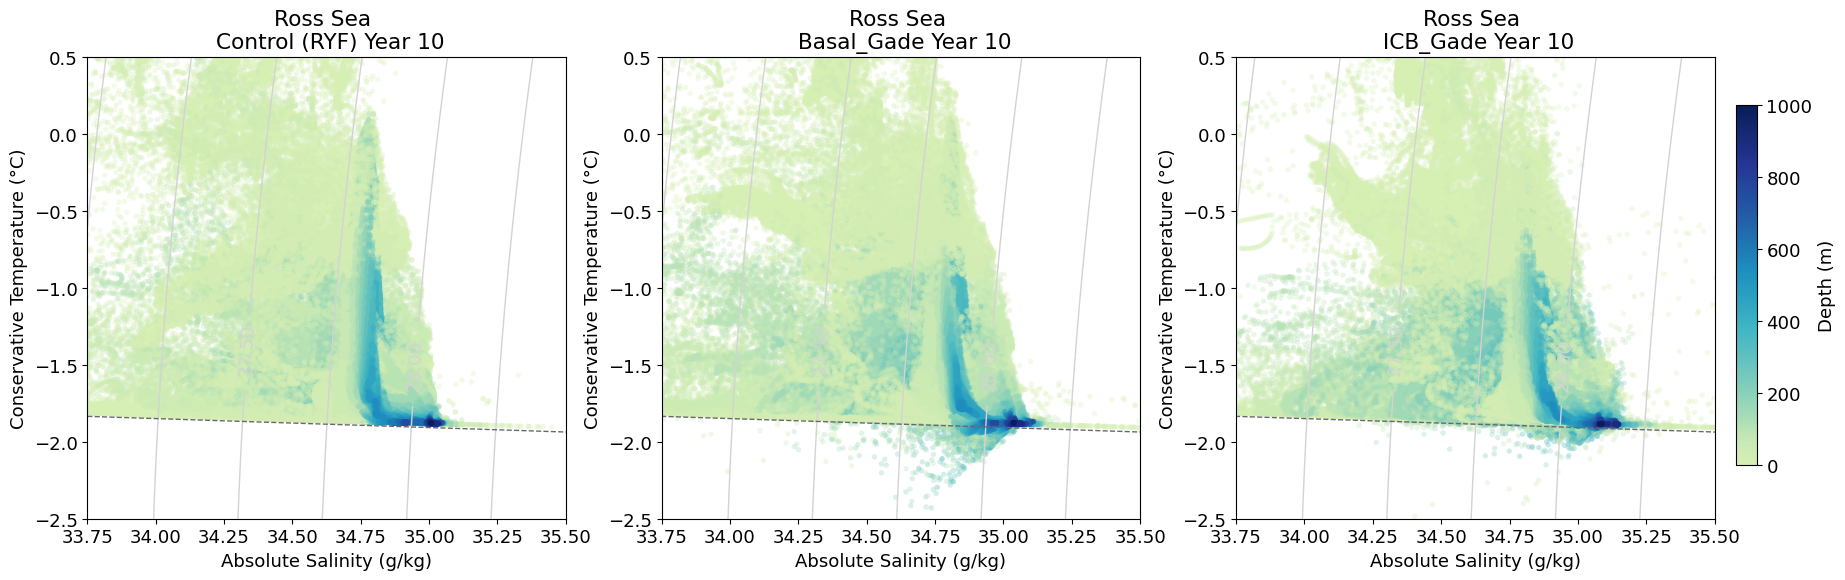

Amundsen Sea (-115, -100, -75.5, -73)
Temp is 0.022302 GB


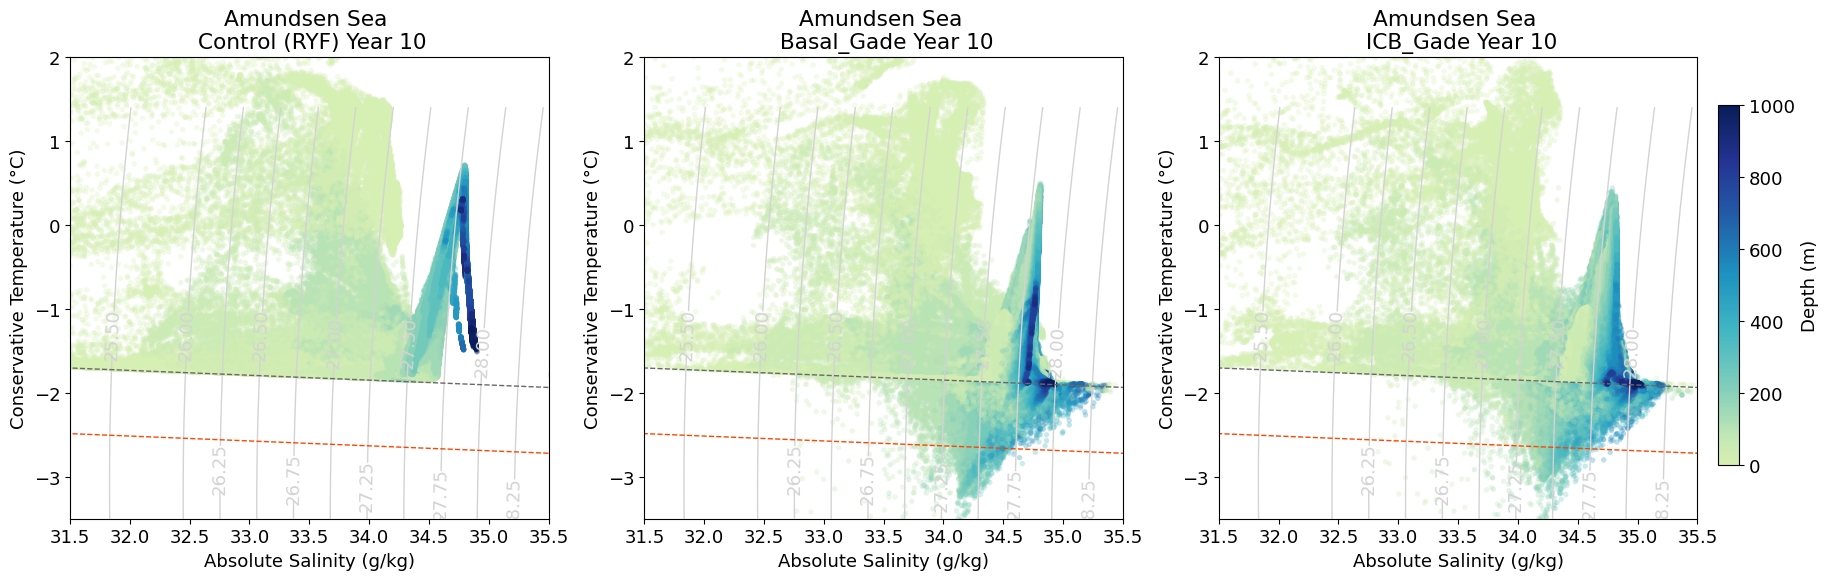

Bellingshausen Sea (-95, -70, -74, -71)
Temp is 0.04473 GB


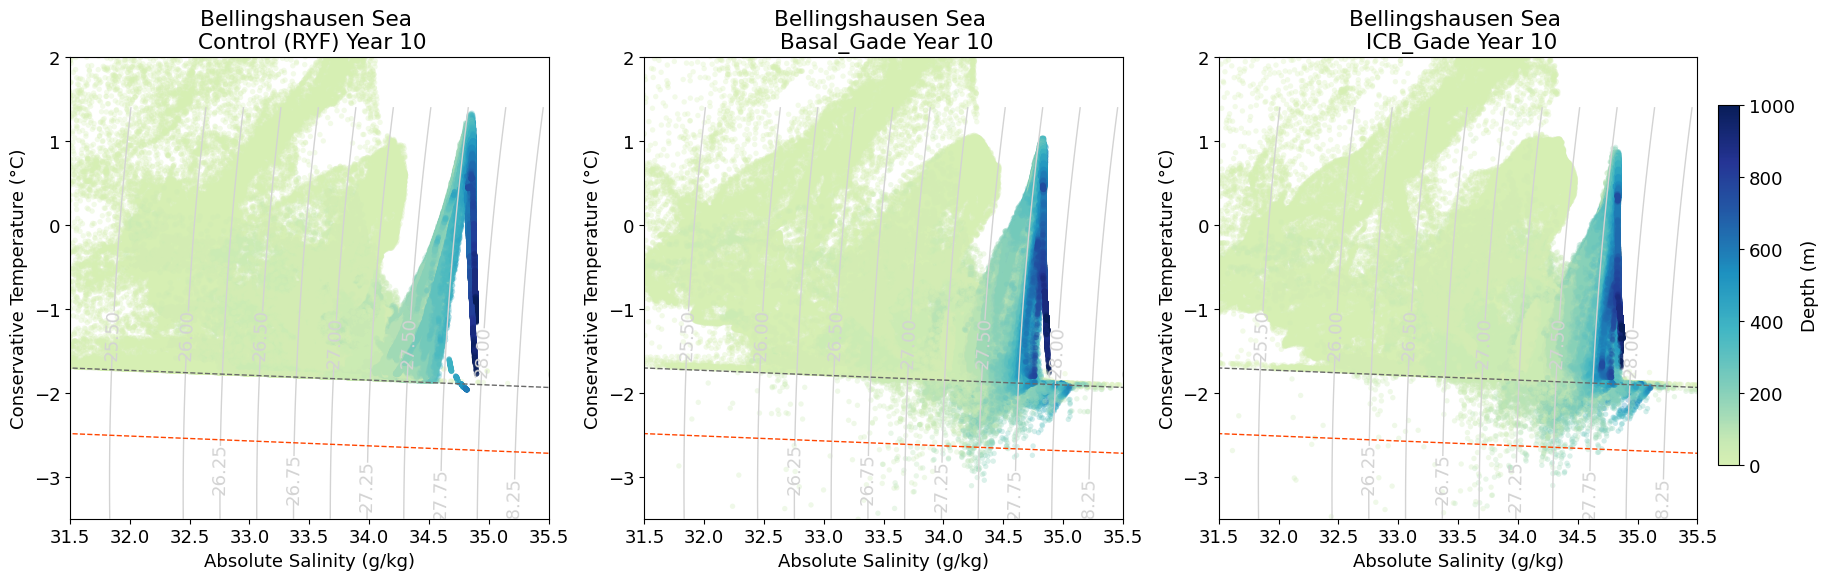

Weddell Sea (-62, -35, -78.5, -74.5)
Temp is 0.064638 GB


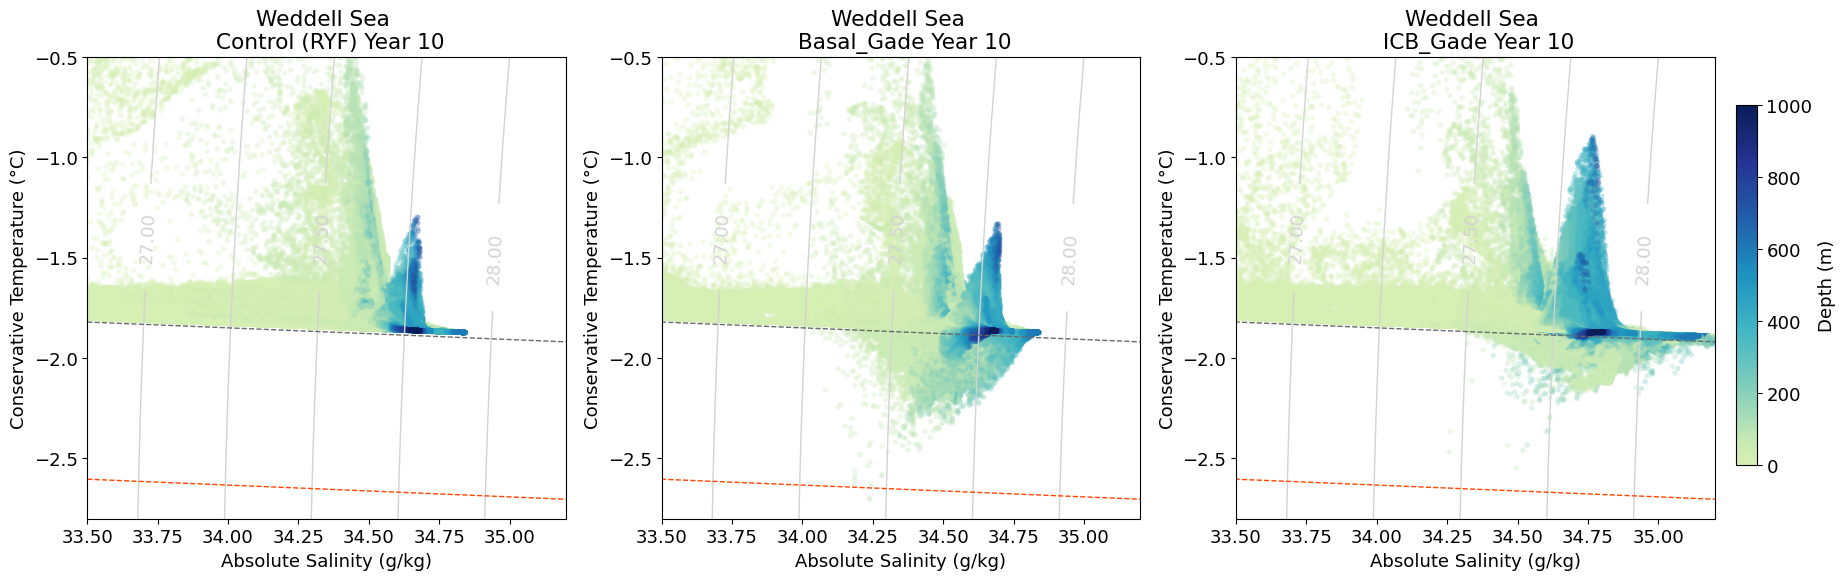

In [113]:
# last year only
start_time='1909-01-01'
end_time='1910-01-01'

for key in bounds:
    print(key, bounds[key])
    l,r,b,t = bounds[key]
    lat_slice = slice(b,t)
    lon_slice = slice(l,r)
    
    # read in T and S for region
    temp,salt,temp_basal_gade,salt_basal_gade,temp_icb_gade,salt_icb_gade = read_and_convert_TS(lat_slice, lon_slice, start_time, end_time)
    
    # create arrays for scatter colouring
    depth, lat_arr = create_colour_array(salt)
    depth_basal, lat_arr_basal = create_colour_array(salt_basal_gade)
    depth_icb, lat_arr_icb = create_colour_array(salt_icb_gade)
    
    # plot figure
    scatter_colour = ['depth']#,'lat']
    s, alph, cmap = 15, 0.3, new_cmap

    sa = np.arange(32,35,0.01)
    t_func_l = -3.4*sa+115.9
    t_func_r1 = 4.5*sa-155.6#155.8
    t_func_r2 = 8*sa-277.3#.43

    for f in range(1):
        fig, axes = figure()
        if scatter_colour[f] == 'depth':
            axes[0].scatter(salt,temp, c=depth, cmap=cmap, alpha=alph, s=s, edgecolors='none')
            axes[1].scatter(salt_basal_gade,temp_basal_gade, c=depth_basal, cmap=cmap, alpha=alph, s=s, edgecolors='none')
            c = axes[1].scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
            axes[2].scatter(salt_icb_gade,temp_icb_gade, c=depth_icb, cmap=cmap, alpha=alph, s=s, edgecolors='none')
            plt.colorbar(c, cax = fig.add_axes([0.91, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')
        else:
            axes[0].scatter(salt,temp, c=lat_arr, cmap=cmap, alpha=alph, s=s, edgecolors='none')
            c = axes[0].scatter(20,0, s=s, c=-70, vmin=lat_arr.min(), vmax=lat_arr.max(), cmap=cmap, alpha=1) # plot dummy point for colorbar sake
            axes[1].scatter(salt_basal_gade,temp_basal_gade, c=lat_arr_basal, cmap=cmap, alpha=alph, s=s, edgecolors='none')
            axes[2].scatter(salt_icb_gade,temp_icb_gade, c=lat_arr_icb, cmap=cmap, alpha=alph, s=s, edgecolors='none')
            plt.colorbar(c, cax = fig.add_axes([0.91, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')

        axes[0].set_title(f'{key} \n Control (RYF) Year 10')
        axes[1].set_title(f'{key} \n Basal_Gade Year 10')
        axes[2].set_title(f'{key} \n ICB_Gade Year 10')
        
        if key == 'Ross Sea':
            for ax in axes.flatten():
                ax.set_xlim([33.75, 35.5])
                ax.set_ylim([-2.5, 0.5])
        elif key == 'Cape Darnley':
            for ax in axes.flatten():
                ax.set_xlim([32.5, 35.8])
                ax.set_ylim([-3, 0.5])
        elif key == 'East Antarctica - Adelie':
            for ax in axes.flatten():
                ax.set_xlim([33, 35.5])
                ax.set_ylim([-3, 1])
        elif key == 'Weddell Sea':
            for ax in axes.flatten():
                ax.set_xlim([33.5, 35.2])
                ax.set_ylim([-2.8, -0.5])
        else:
            for ax in axes.flatten():
                ax.set_xlim([31.5, 35.5])
                ax.set_ylim([-3.5, 2.0])
            
        plt.show()
        
        